# Tardiness

- Tardiness = 0, wenn der Auftrag rechtzeitig oder sogar vorzeitig fertiggestellt wurde.
- Tardiness > 0, wenn der Auftrag später fertiggestellt wird als ursprünglich vorgesehen
- berücksichtigt nur positive Abweichungen, also nur tatsächliche Verspätungen.

$$
T_j = \max(0,\; C_j - d_j)
$$


- $T_j$: Tardiness (Verspätung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $T_j > 0$: Job ist **verspätet**  
- $T_j = 0$: Job ist **pünktlich oder zu früh**  
- Frühfertigungen werden **nicht bestraft**, sondern zu $0$ gesetzt

In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline

# Solver Model
from src.models.lp import tardiness_scheduling as lp_tardiness
import src.models.heuristics.fcfs as fcfs

# Extern
import pandas as pd
pd.set_option('display.max_rows', 21)

In [2]:
max_time = 60 * 5 # 5 min

In [3]:
basic_data_path = get_path("data", "basic")
day_count = 1

df_instance = pd.read_csv(basic_data_path / "instance.csv")
df_jssp, df_job_arrivals = init.create_production_orders_for_shifts(df_template=df_instance, shift_count=day_count,
                                                                 u_b_mmax= 0.94, shift_length=1440, shuffle=True,
                                                                 job_seed=40, arrival_seed=80)
df_job_arrivals

,Job,Production_Plan_ID,Arrival
0,0,0,49
1,1,1,130
2,2,2,151
3,3,3,226
4,4,4,386
5,5,5,464
6,6,6,480
7,7,7,506
8,8,8,526
9,9,9,535


In [4]:
df_job_times = gen_deadline.get_times_df(df_jssp, df_job_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_job_times


Schedule-Informationen:
  Makespan: 2400


,Job,Production_Plan_ID,Arrival,Deadline
0,0,0,49,848.0
1,1,1,130,1162.0
2,2,2,151,1300.0
3,3,3,226,1551.0
4,4,4,386,1181.0
5,5,5,464,1467.0
6,6,6,480,1322.0
7,7,7,506,1596.0
8,8,8,526,1734.0
9,9,9,535,1627.0


## a) Summe der Tardiness minimieren

$$
\min \; \sum_{j \in J} \max(0,\; C_j - d_j)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness von Job $j$  
- Die Summe betrachtet **nur verspätete Jobs** – Frühfertigungen zählen nicht.

**Erklärung:**  
Diese Zielfunktion minimiert die **Gesamtheit aller Verspätungen**, d. h. die Summe aller positiven Abweichungen von den Deadlines.

In [5]:
# Scheduling
df_schedule = lp_tardiness.solve_jssp_sum(df_jssp, df_job_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)
df_schedule

BigM: 6000

Solver-Informationen:
  Summe Tardiness         : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 2140
  Anzahl Constraints      : 4020
  Laufzeit                : ~88 Sekunden


,Job,Production_Plan_ID,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,0,0,0,49,848.0,M00,49.0,29.0,78.0,0
1,0,0,1,49,848.0,M01,78.0,78.0,156.0,0
2,1,1,0,130,1162.0,M00,130.0,43.0,173.0,0
3,0,0,2,49,848.0,M02,156.0,9.0,165.0,0
4,2,2,0,151,1300.0,M01,156.0,91.0,247.0,0
...,...,...,...,...,...,...,...,...,...,...
195,17,3,7,1285,2610.0,M03,2351.0,98.0,2449.0,0
196,18,5,8,1397,2400.0,M04,2368.0,6.0,2374.0,0
197,18,5,9,1397,2400.0,M07,2374.0,25.0,2399.0,0
198,17,3,8,1285,2610.0,M09,2449.0,22.0,2471.0,0


In [6]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

label
0            200
0 - 60         0
60 - 120       0
120 - 180      0
>180           0
Name: count, dtype: int64

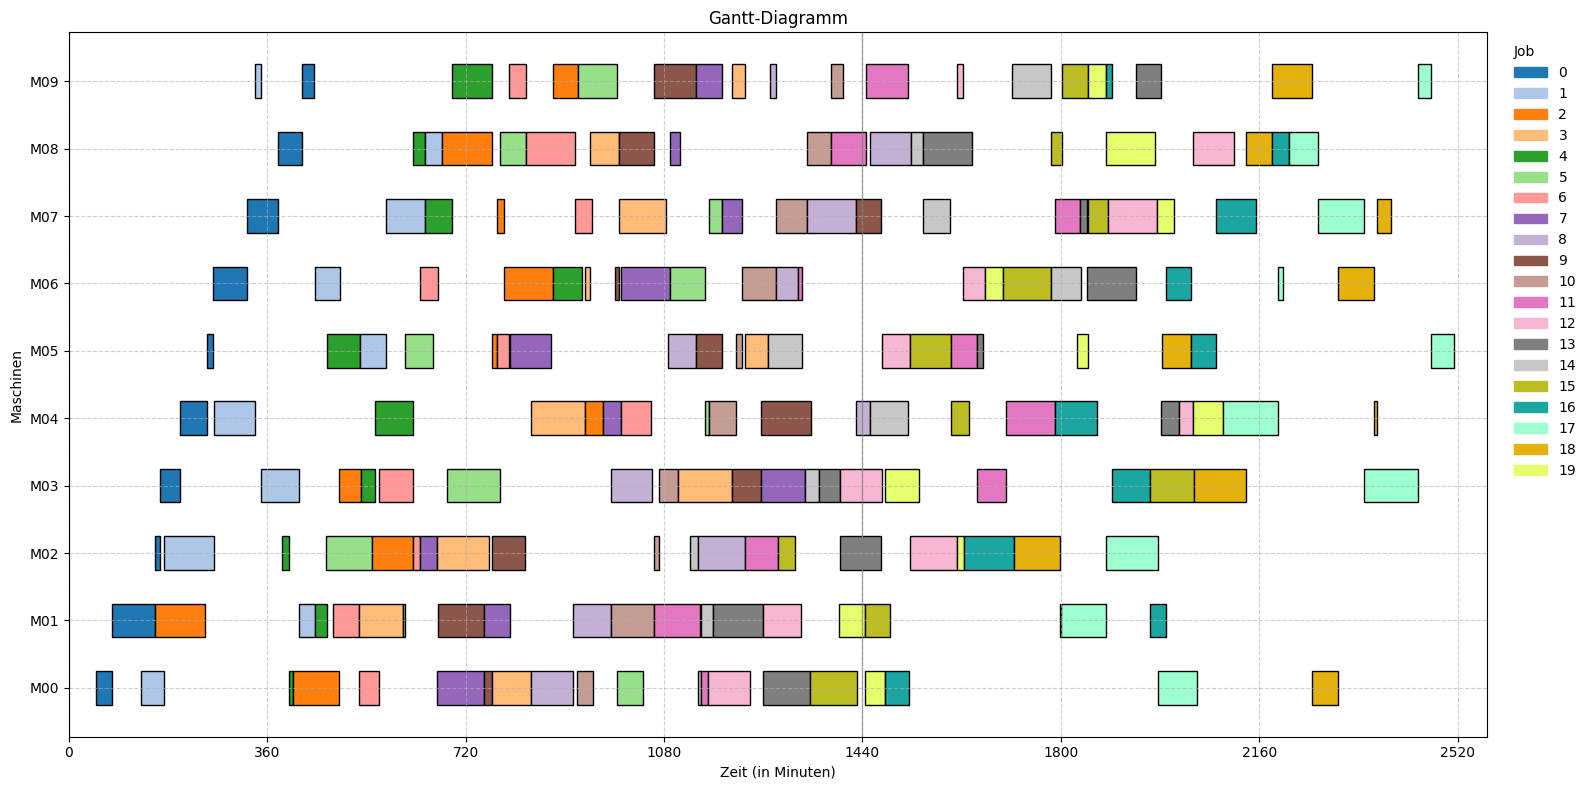

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [7]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

## b) größte Tardiness minimieren

$$
\min \; \max_{j \in J} \left( \max(0,\; C_j - d_j) \right)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness des Jobs $j$  
- Die äußere $\max$-Funktion bestimmt den Job mit der **größten Verspätung**

**Erklärung:**  
Diese Zielfunktion minimiert die **schlimmste Deadline-Überschreitung** unter allen Jobs. Frühfertigungen fließen dabei **nicht** ein.


In [8]:
# Scheduling
df_schedule = lp_tardiness.solve_jssp_max(df_jssp, df_job_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)
df_schedule

BigM: 6000

Solver-Informationen:
  Maximale Tardiness      : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 2141
  Anzahl Constraints      : 4040
  Laufzeit                : ~23 Sekunden


,Job,Production_Plan_ID,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,0,0,0,49,848.0,M00,49.0,29.0,78.0,0
1,0,0,1,49,848.0,M01,78.0,78.0,156.0,0
2,1,1,0,130,1162.0,M00,130.0,43.0,173.0,0
3,0,0,2,49,848.0,M02,156.0,9.0,165.0,0
4,0,0,3,49,848.0,M03,165.0,36.0,201.0,0
...,...,...,...,...,...,...,...,...,...,...
195,18,5,9,1397,2400.0,M07,2337.0,25.0,2362.0,0
196,17,3,6,1285,2610.0,M07,2362.0,85.0,2447.0,0
197,17,3,7,1285,2610.0,M03,2447.0,98.0,2545.0,0
198,17,3,8,1285,2610.0,M09,2545.0,22.0,2567.0,0


In [12]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

label
0            20
0 - 60        0
60 - 120      0
120 - 180     0
>180          0
Name: count, dtype: int64


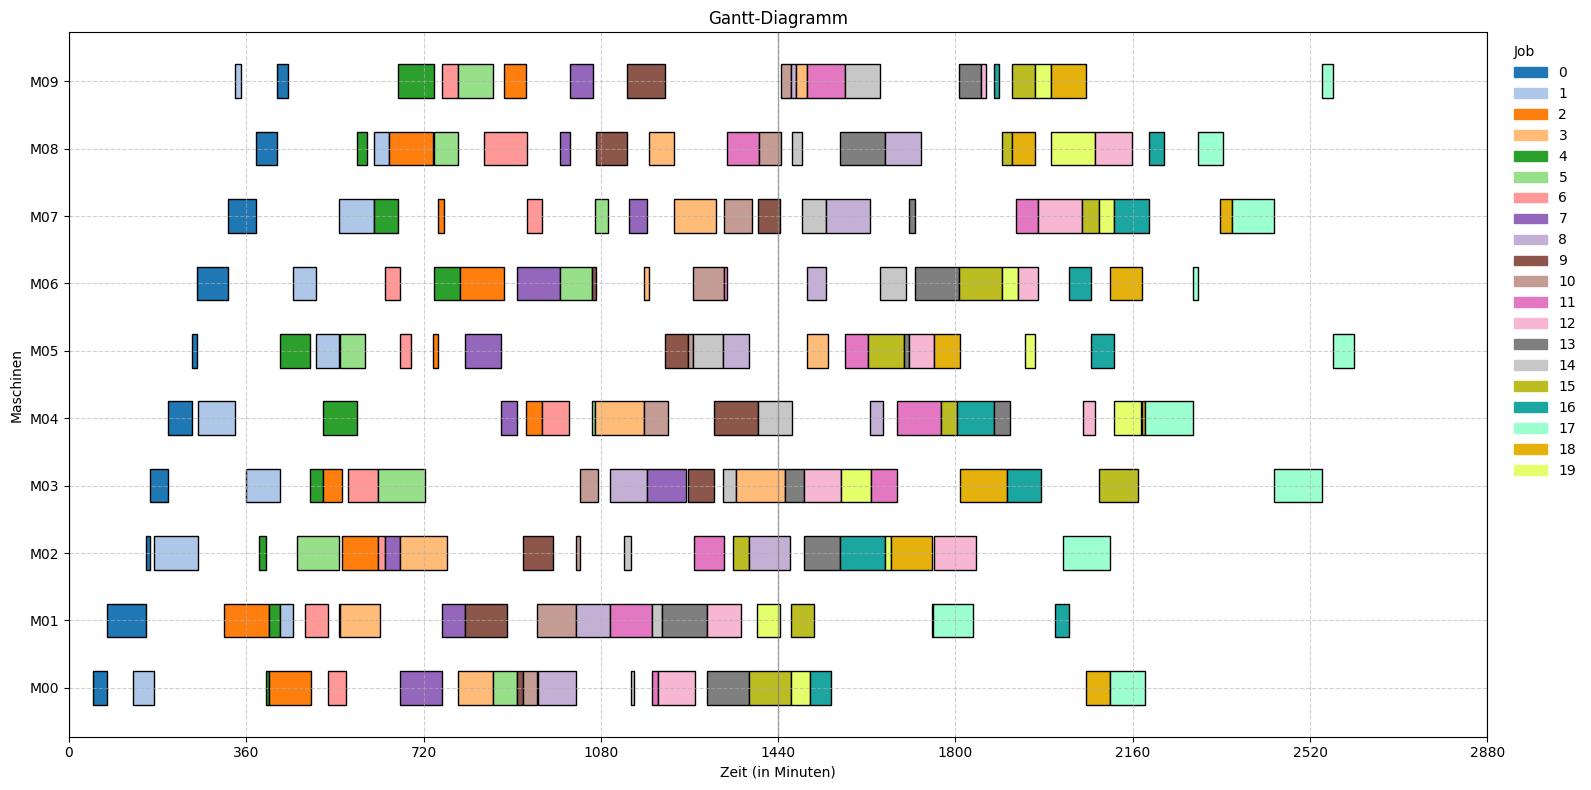

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [10]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)